In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
# Use the file with embedding features
FEATURES_PREPPED_FILE = "features_prepped_with_neighbors.csv"
TRAIN_TEST_SPLIT = 0.9
VAL_TEST_SPLIT = 0.9
START_DATE = datetime(2025,9,8) + timedelta(days=28)
BAD_FEATURES = []
TOP_100 = [2637208, 2674067, 2674069, 2677746, 2691590, 2739813, 2813189, 2813194, 2813195, 2819449, 2822887, 2840431, 2841189, 2855586, 2855595, 2857178, 3690505, 3690510, 4039724, 4189521, 4463773, 4580598, 5192206, 5192221, 5192225, 5245545, 5257669, 5658823, 5664444, 5683132, 5683135, 5683137, 5698506, 5698507, 5703921, 5710675, 5730396, 5823149, 5823150, 5850773, 5851707, 5955504, 5955510, 5955515, 5973485, 6049412, 6049413, 6256793, 6451779, 7210406, 7249979, 7379752, 7622814, 7622840, 7635753, 7653413, 7855462, 7869313, 7915951, 7917434, 7917436, 7922326, 8152638, 8152776, 8152803, 8152804, 8217944, 8422222, 8596633, 8858060, 8880222, 8966982, 8971859, 8972128, 9209729, 9245542, 9256674, 9603028, 9603030, 9603032, 9603035, 9656727, 9680118, 9724035, 10041062, 10041066, 10648067, 11061680, 11562016, 11562019, 12120522, 12168743, 12376820, 12376825, 12681178, 12744603, 13419273, 13536691, 14158330, 14234253]

In [3]:
df = pd.read_csv(FEATURES_PREPPED_FILE)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(by='date')
df = df[df['date'] >= START_DATE]
print(f"Loaded {len(df)} rows")

Loaded 147446 rows


In [4]:
feature_cols = [col for col in df.columns if col not in ['universal_gemrate_id', 'spec_id', 'date', 'price'] and col not in BAD_FEATURES]
print(f"Total features: {len(feature_cols)}")

Total features: 147


In [5]:
train_df = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT)]
test_df = df.iloc[int(len(df) * TRAIN_TEST_SPLIT):]
val_df = test_df.iloc[:int(len(test_df) * VAL_TEST_SPLIT)]
test_df = test_df.iloc[int(len(test_df) * VAL_TEST_SPLIT):]

# val_df = val_df.loc[val_df["prev_1_price"].isna()]
# val_df = val_df.dropna(subset=['neighbor_1_avg_price'])
# test_df = test_df.loc[test_df["prev_1_price"].isna()]
# test_df = test_df.dropna(subset=['emb_neighbor_1_price'])
# val_df = val_df.loc[val_df["spec_id"].isin(TOP_100)]
# test_df = test_df.loc[test_df["spec_id"].isin(TOP_100)]
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
val_df["date"].min()

Train: 132701, Val: 13270, Test: 1475


Timestamp('2025-12-01 00:00:00')

In [6]:
X_train = train_df[feature_cols].copy()
y_train = train_df['price'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['price'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['price'].copy()

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {len(feature_cols)}")

Training set: 132701 samples
Validation set: 13270 samples
Test set: 1475 samples
Number of features: 147


In [7]:
model = XGBRegressor(device='cuda')

# Define parameter grid
param_grid = {
    'max_depth': [10],
    'learning_rate': [0.075],
    'n_estimators': [150],
    'min_child_weight': [30],
    'subsample': [0.9],
    'colsample_bytree': [1.0],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [5],
    'colsample_bylevel': [0.7],
    'max_delta_step': [0],
}

best_score = 99999
best_grid = {}
for g in ParameterGrid(param_grid):
    model.set_params(**g)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_val_pred = np.exp(y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)
    print(f"MAPE: {mape:.2%}")
    if mape < best_score:
        best_score = mape
        best_grid = g
    print(f"Best MAPE: {best_score:.2%}")

print("Best MAPE: %0.5f" % best_score)
print("Best Grid:", best_grid)

MAPE: 245898.21%
Best MAPE: 245898.21%
Best MAPE: 2458.98212
Best Grid: {'colsample_bylevel': 0.7, 'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.075, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 30, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.9}


/root/sync/ava/collector_crypt/.venv/lib/python3.13/site-packages/xgboost/core.py:774: UserWarning: [13:50:45] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [8]:
best_model = XGBRegressor(device='cuda')
best_model.set_params(**best_grid)
best_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.7
,colsample_bynode,None
,colsample_bytree,1.0
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [9]:
y_val = np.exp(y_val)
y_val_pred = best_model.predict(X_val)
y_val_pred = np.exp(y_val_pred)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

simple_percent_error = (np.abs(X_val["prev_1_price"].values - y_val.values) / y_val.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
percent_error = (np.abs(y_val_pred - y_val.values) / y_val.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Validation Metrics:")
print(f"  RMSE: ${val_rmse:,.2f}")
print(f"  MAE:  ${val_mae:,.2f}")
print(f"  MAPE: {val_mape:.2%}")
print(f"  R²:   {val_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

Validation Metrics:
  RMSE: $37,904.74
  MAE:  $6,283.61
  MAPE: 20.93%
  R²:   0.8186

Simple Percent Error Percentiles:
count    12477.000000
mean        99.877067
std          0.125879
min         96.266314
10%         99.747187
20%         99.807235
30%         99.845059
40%         99.878730
50%         99.907982
60%         99.934525
70%         99.954386
80%         99.966465
90%         99.982009
max         99.999329
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    13270.000000
mean        20.928490
std         53.586063
min          0.000420
10%          1.991645
20%          4.019362
30%          6.316378
40%          9.026371
50%         11.976383
60%         15.963357
70%         20.964602
80%         28.472247
90%         43.418020
max       3673.959375
Name: percent_error, dtype: float64


In [10]:
y_test = np.exp(y_test)
y_test_pred = best_model.predict(X_test)
y_test_pred = np.exp(y_test_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

simple_percent_error = (np.abs(X_test["prev_1_price"].values - y_test.values) / y_test.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
percent_error = (np.abs(y_test_pred - y_test.values) / y_test.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Test Metrics:")
print(f"  RMSE: ${test_rmse:,.2f}")
print(f"  MAE:  ${test_mae:,.2f}")
print(f"  MAPE: {test_mape:.2%}")
print(f"  R²:   {test_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

Test Metrics:
  RMSE: $18,987.55
  MAE:  $4,671.41
  MAPE: 24.02%
  R²:   0.9036

Simple Percent Error Percentiles:
count    1380.000000
mean       99.855324
std         0.192877
min        96.294222
10%        99.723660
20%        99.789174
30%        99.830920
40%        99.859296
50%        99.891870
60%        99.923948
70%        99.948153
80%        99.964521
90%        99.977843
max        99.998402
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    1475.000000
mean       24.021382
std        41.654593
min         0.026525
10%         1.985518
20%         4.299831
30%         6.957607
40%         9.826082
50%        13.357958
60%        17.398489
70%        23.590628
80%        32.268031
90%        51.567830
max       723.635840
Name: percent_error, dtype: float64


In [11]:
y_test

186329     7300.0
127688    10000.0
127687    10355.0
175084     3100.0
224353    18750.0
           ...   
48196      3100.0
53820     11103.0
51064     14650.0
54711      4000.0
76091     29700.0
Name: price, Length: 1475, dtype: float64

In [12]:
y_test_pred

array([ 4874.6943, 10281.927 , 12226.193 , ..., 10596.611 ,  6413.454 ,
       14235.63  ], shape=(1475,), dtype=float32)

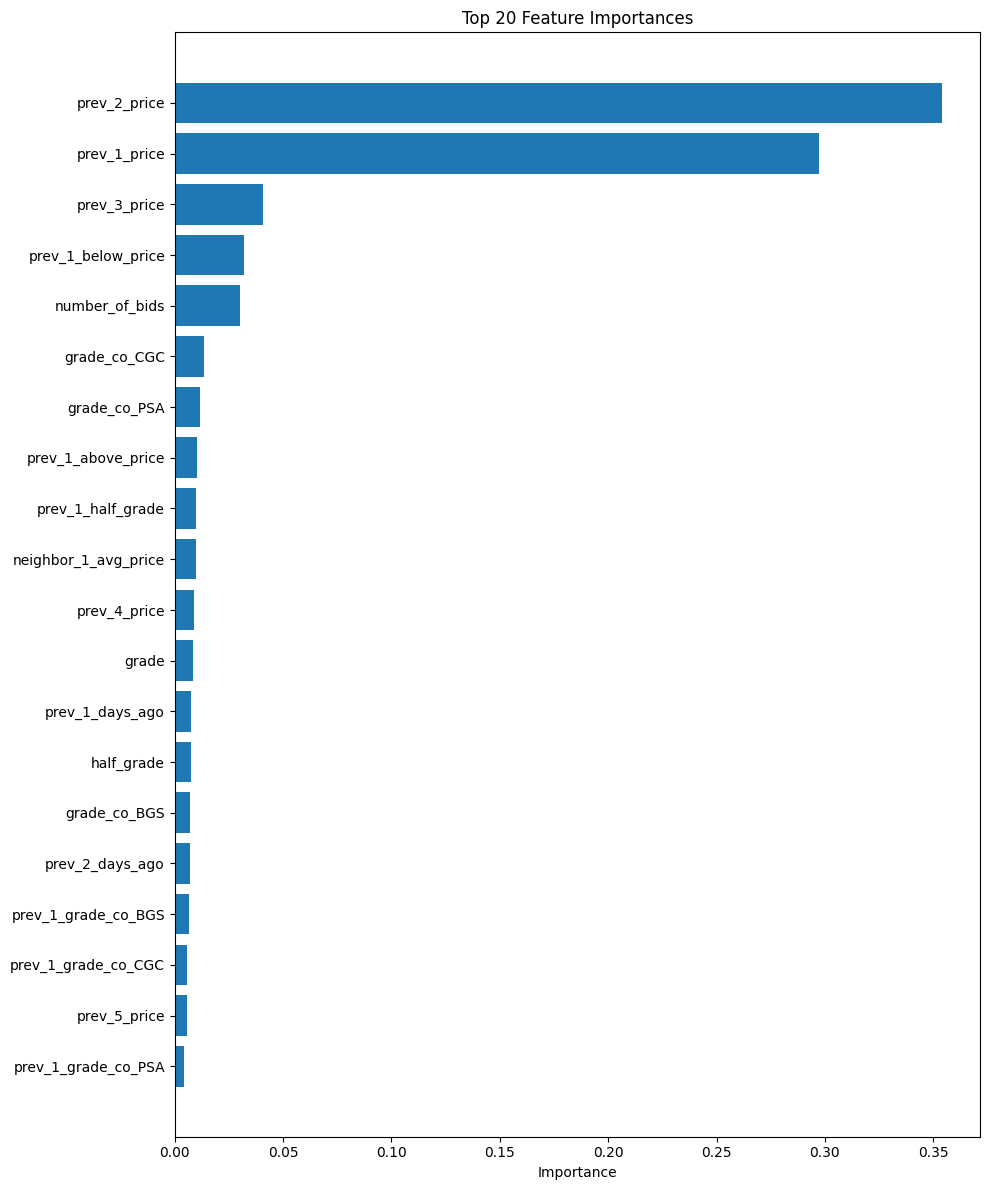

,feature,importance
14,prev_2_price,0.353868
8,prev_1_price,0.297094
20,prev_3_price,0.040584
97,prev_1_below_price,0.032090
2,number_of_bids,0.030332
4,grade_co_CGC,0.013504
5,grade_co_PSA,0.011537
62,prev_1_above_price,0.010318
9,prev_1_half_grade,0.010009
137,neighbor_1_avg_price,0.009785


In [13]:
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df.head(20)

In [14]:
importance_df["importance_cumsum"] = importance_df["importance"].cumsum()
importance_df

,feature,importance,importance_cumsum
14,prev_2_price,0.353868,0.353868
8,prev_1_price,0.297094,0.650962
20,prev_3_price,0.040584,0.691546
97,prev_1_below_price,0.032090,0.723636
2,number_of_bids,0.030332,0.753968
...,...,...,...
130,prev_5_below_seller_popularity,0.000410,0.998884
116,prev_3_below_seller_popularity,0.000403,0.999287
28,prev_4_grade_co_BGS,0.000393,0.999680
91,prev_5_above_half_grade,0.000320,1.000000


In [15]:
bad_features = importance_df[importance_df["importance_cumsum"] > 0.95]["feature"]
list(bad_features)

['prev_5_below_grade_co_PSA',
 'prev_4_below_grade_co_BGS',
 'prev_3_half_grade',
 'prev_5_grade_co_PSA',
 'prev_3_above_price',
 'prev_2_above_grade_co_CGC',
 'prev_5_above_price',
 'prev_3_below_grade_co_BGS',
 'prev_3_above_grade_co_PSA',
 'avg_grade_co_CGC_1w_ago',
 'neighbor_2_similarity',
 'prev_2_below_days_ago',
 'prev_5_grade_co_CGC',
 'avg_grade_co_CGC_2w_ago',
 'prev_2_below_half_grade',
 'prev_3_above_grade_co_CGC',
 'prev_5_below_half_grade',
 'prev_4_below_grade_co_CGC',
 'neighbor_3_similarity',
 'avg_grade_co_PSA_1w_ago',
 'prev_5_below_grade_co_CGC',
 'prev_3_above_half_grade',
 'avg_grade_co_CGC_3w_ago',
 'prev_1_above_seller_popularity',
 'prev_5_below_days_ago',
 'neighbor_4_similarity',
 'prev_4_below_days_ago',
 'prev_4_below_half_grade',
 'prev_2_below_grade_co_BGS',
 'prev_2_above_grade_co_BGS',
 'prev_2_above_grade_co_PSA',
 'prev_2_above_days_ago',
 'prev_4_above_grade_co_CGC',
 'neighbor_5_similarity',
 'prev_5_above_days_ago',
 'avg_grade_co_PSA_3w_ago',
 'p

## Prediction Intervals with Quantile Regression

Train additional XGBoost models to predict lower and upper bounds using quantile regression.
This provides uncertainty estimates for each prediction.

In [16]:
# Train quantile regression models for prediction intervals
# Lower bound (10th percentile) and upper bound (90th percentile)

LOWER_QUANTILE = 0.1
UPPER_QUANTILE = 0.9

# Create quantile regression models using the same hyperparameters as the best model
quantile_params = best_grid.copy()

# Train lower bound model
model_lower = XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=LOWER_QUANTILE,
    device='cuda',
    **quantile_params
)
model_lower.fit(X_train, y_train)
print(f"Lower bound model (q={LOWER_QUANTILE}) trained")

# Train upper bound model
model_upper = XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=UPPER_QUANTILE,
    device='cuda',
    **quantile_params
)
model_upper.fit(X_train, y_train)
print(f"Upper bound model (q={UPPER_QUANTILE}) trained")

Lower bound model (q=0.1) trained
Upper bound model (q=0.9) trained


In [17]:
# Generate prediction intervals for test set
y_test_pred_lower = np.exp(model_lower.predict(X_test))
y_test_pred_upper = np.exp(model_upper.predict(X_test))
y_test_pred_median = y_test_pred  # Use point prediction as median

# Calculate interval coverage (percentage of actual values within predicted interval)
in_interval = (y_test.values >= y_test_pred_lower) & (y_test.values <= y_test_pred_upper)
coverage = in_interval.mean()

# Calculate average interval width
interval_width = y_test_pred_upper - y_test_pred_lower
avg_interval_width = interval_width.mean()
relative_interval_width = (interval_width / y_test_pred_median).mean()

print(f"\nPrediction Interval Metrics (Test Set):")
print(f"  Target Coverage: {(UPPER_QUANTILE - LOWER_QUANTILE) * 100:.0f}%")
print(f"  Actual Coverage: {coverage * 100:.1f}%")
print(f"  Average Interval Width: ${avg_interval_width:,.2f}")
print(f"  Relative Interval Width: {relative_interval_width * 100:.1f}% of predicted price")


Prediction Interval Metrics (Test Set):
  Target Coverage: 80%
  Actual Coverage: 77.2%
  Average Interval Width: $14,901.87
  Relative Interval Width: 72.0% of predicted price


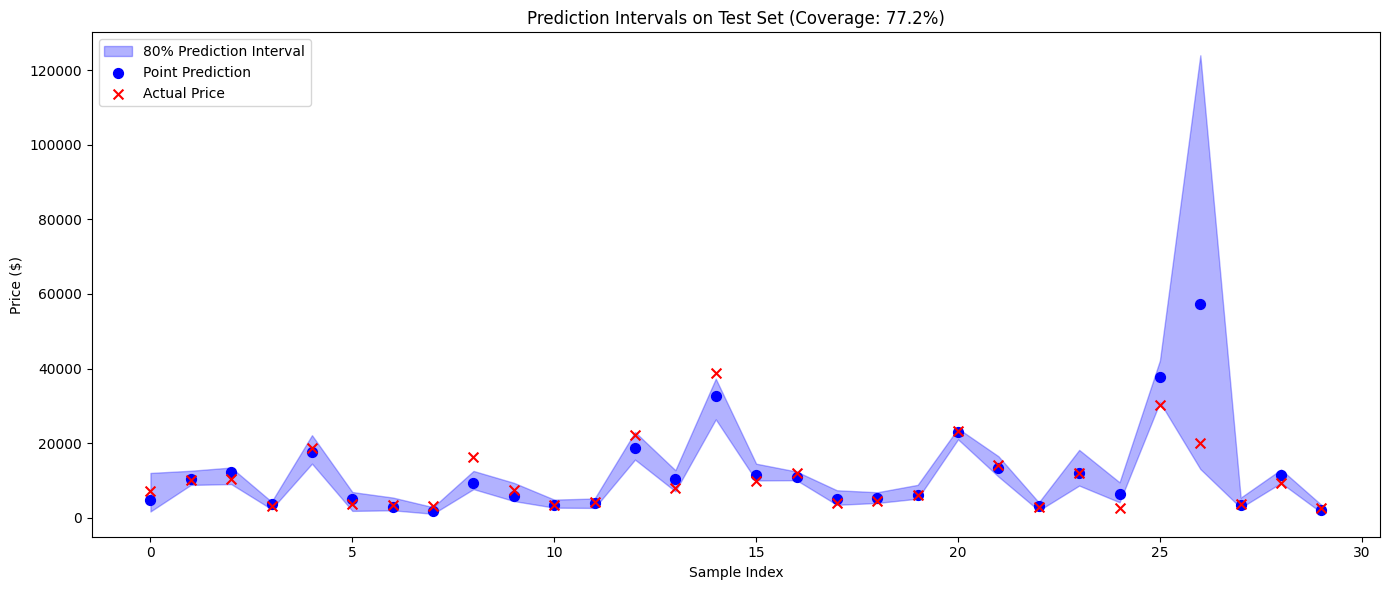

In [18]:
# Visualize prediction intervals for a sample of test predictions
n_samples = min(30, len(y_test))
sample_indices = np.arange(n_samples)

plt.figure(figsize=(14, 6))

# Plot prediction intervals
plt.fill_between(sample_indices, 
                 y_test_pred_lower[:n_samples], 
                 y_test_pred_upper[:n_samples], 
                 alpha=0.3, color='blue', label=f'{int((UPPER_QUANTILE-LOWER_QUANTILE)*100)}% Prediction Interval')

# Plot point predictions
plt.scatter(sample_indices, y_test_pred_median[:n_samples], 
            color='blue', s=50, zorder=3, label='Point Prediction')

# Plot actual values
plt.scatter(sample_indices, y_test.values[:n_samples], 
            color='red', s=50, marker='x', zorder=4, label='Actual Price')

plt.xlabel('Sample Index')
plt.ylabel('Price ($)')
plt.title(f'Prediction Intervals on Test Set (Coverage: {coverage*100:.1f}%)')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Create a summary DataFrame with predictions and intervals
predictions_df = pd.DataFrame({
    'actual_price': y_test.values,
    'predicted_price': y_test_pred_median,
    'lower_bound': y_test_pred_lower,
    'upper_bound': y_test_pred_upper,
    'interval_width': interval_width,
    'in_interval': in_interval
})

predictions_df['error'] = predictions_df['actual_price'] - predictions_df['predicted_price']
predictions_df['percent_error'] = (np.abs(predictions_df['error']) / predictions_df['actual_price']) * 100

print("\nPredictions with Intervals:")
predictions_df.head(15)


Predictions with Intervals:


,actual_price,predicted_price,lower_bound,upper_bound,interval_width,in_interval,error,percent_error
0,7300.0,4874.694336,1683.808350,12014.693359,10330.884766,True,2425.305664,33.223365
1,10000.0,10281.926758,8806.533203,12598.112305,3791.579102,True,-281.926758,2.819268
2,10355.0,12226.193359,9026.480469,13463.505859,4437.025391,True,-1871.193359,18.070433
3,3100.0,3591.578369,2308.165527,4304.258301,1996.092773,True,-491.578369,15.857367
4,18750.0,17667.748047,14506.396484,22128.833984,7622.437500,True,1082.251953,5.772010
5,3800.0,5030.556641,1843.425049,6893.078613,5049.653320,True,-1230.556641,32.383069
6,3300.0,2935.380615,2000.495117,5422.733398,3422.238281,True,364.619385,11.049072
7,3200.0,1707.222656,1066.044312,2839.043457,1772.999146,False,1492.777344,46.649292
8,16250.0,9324.929688,7680.322754,12546.962891,4866.640137,False,6925.070313,42.615817
9,7500.0,5724.626465,4476.591309,9365.275391,4888.684082,True,1775.373535,23.671647
